
#### Prabhav Ravi Tammanashastri - BL.EN.U4CSE21162
#### Vijayakumar Soorya - BL.EN.U4CSE21220
#### Kandukuri Jashwanth - BL.EN.U4CSE21088

<a href="https://colab.research.google.com/github/PieterDujardin/NER/blob/master/ColabNotebooks/i2b2_2010/BERT_on_i2b2_2010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import statements

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
%pip install transformers
%pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=13a0c50f1460b9905bf8f0939a24b0c51c0efedbee7ab720e028ef5c311eb091
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
# %pip list | grep -E 'transformers|torch|Keras'

In [4]:
# %pip list

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
import csv
import time
import datetime
import io
import math
import os
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm,trange
from seqeval.metrics import f1_score
from seqeval.metrics import classification_report,accuracy_score,f1_score
# from sklearn.metrics import f1_score
from transformers import BertTokenizer, BertConfig, AutoConfig, AutoTokenizer
from transformers import BertForTokenClassification, AdamW, AutoModel, CamembertTokenizer, CamembertForTokenClassification
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
import torch.nn.functional as F
from transformers import get_linear_schedule_with_warmup

# Cuda

In [6]:
torch.cuda.is_available()

True

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [8]:
n_gpu

1

In [9]:
# torch.cuda.get_device_name()
#tesla K80 is used by pytorch

In [10]:
torch.cuda.get_device_properties('cuda')

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)

In [11]:
torch.cuda.current_device()

0

In [12]:
torch.cuda.device(0)

In [13]:
#free memory
torch.cuda.empty_cache()

# 1. Functions

In [14]:
def loadandformat(datasets):

    # data=[]
    # for dataset in datasets:
    #   # the training, dev and test set in one file
    #   with open('drive/My Drive/Colab Notebooks/BERTwithNER3/conll2003format/{}'.format(dataset),'r') as f:
    #       data +=  f.readlines()
    sentence=[]
    sentences=[]
    for dataset in datasets:
      with open('/content/{}'.format(dataset),'r') as f:
        for line in f:
          if line == '\n':
              sentences.append(sentence)
              sentence=[]
          else:
              sentence.append(line)

    for sent in range(len(sentences)):
      for word in range(len(sentences[sent])):
          sentences[sent][word] = str(sentences[sent][word]).replace('\t',' ')
          sentences[sent][word] = str(sentences[sent][word]).rstrip('\n')
          sentences[sent][word]= str(sentences[sent][word]).split()

    sentenceslabels =[]
    sentencestext =[]

    placeholder0=[]
    placeholder1=[]

    for sent in range(len(sentences)):
      for word in range(len(sentences[sent])):
          placeholder0.append(sentences[sent][word][1])
          placeholder1.append(sentences[sent][word][0])

      sentenceslabels.append(placeholder0)
      sentencestext.append(placeholder1)
      placeholder0=[]
      placeholder1=[]

    joinedlist =[]
    for i in range(len(sentenceslabels)-1):
      joinedlist.extend(sentenceslabels[i])

    tags_vals = list(set(joinedlist))

    tags_vals.append('X')
    tags_vals.append('[CLS]')
    tags_vals.append('[SEP]')

    tag2idx = {t: i for i, t in enumerate(tags_vals)}
    tag2name={tag2idx[key] : key for key in tag2idx.keys()}


    return (sentencestext,sentenceslabels,tags_vals,tag2idx,tag2name)

In [15]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [16]:
def extract_dict_with_frequency_of_UNKwords():
    '''return a dict with frequency of UNKwords that satisfy a condition'''

    my_list = []
    for word_list,label in (zip(sentences,labels)):
        for word,lab in zip(word_list,label):
            token_list = tokenizer.tokenize(word)
            if token_list == ['[UNK]'] and lab != 'O' and len(word)>= 6:
                my_list.append(word)
    freq = {}
    for item in my_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1

    for key, value in freq.items():
        print ("% s : % d"%(key, value))
    return freq

In [17]:
def addUNKtokenstovocab(freqdict):
    '''add the words of freq dict to vocab'''
    list1 = list(freqdict.keys())
    for word in list1:
        tokenizer.add_tokens(word)
    print(list1)


In [18]:
def maketextuallyreadforinput(sentences,labels):
    tokenized_texts = []
    word_piece_labels = []

    i_inc = 0

    for word_list,label in (zip(sentences,labels)):
    #temp label and temp token are the 1 sentence labels and tokens

        temp_label = []
        temp_token = []

        # Add [CLS] at the front
        temp_label.append('[CLS]')
        temp_token.append('[CLS]')

        for word,lab in zip(word_list,label):
            token_list = tokenizer.tokenize(word)
            for m,token in enumerate(token_list):
                temp_token.append(token)
                if m==0:
                    temp_label.append(lab)
                else:
                    temp_label.append('X')

        # Add [SEP] at the end
        temp_label.append('[SEP]')
        temp_token.append('[SEP]')

        tokenized_texts.append(temp_token)
        word_piece_labels.append(temp_label)

        if 50 > i_inc >= 0:
            print("No.%d,len:%d"%(i_inc,len(temp_token)))
            print("texts:%s"%(" ".join(temp_token)))
            print("No.%d,len:%d"%(i_inc,len(temp_label)))
            print("lables:%s"%(" ".join(temp_label)))
        i_inc +=1

    return (tokenized_texts,word_piece_labels)

In [19]:
def convertokens(max_len,tokenized_texts,word_piece_labels,sentences):
    # Do-something if <condition>, else do-something else.
    input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                        maxlen=max_len, dtype="long", truncating="post", padding="post")

    tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in word_piece_labels],
                  maxlen=max_len, value=tag2idx["O"], padding="post",
                  dtype="long", truncating="post")


    attention_masks_deprecated = [[int(i>0) for i in ii] for ii in input_ids]
    segment_ids = [[0] * len(input_id) for input_id in input_ids]

    allsentences = []
    for sentence in sentences:
        sentence = ' '.join(sentence)
    #     print(sentence)
        allsentences.append(sentence)

    attention_masks = pad_sequences(tokenizer.batch_encode_plus(allsentences)['attention_mask'],
                            maxlen=max_len, dtype="long", truncating="post", padding="post")

#     print(pad_sequences(tokenizer.batch_encode_plus(sentences)['input_ids'][0:2],
#                             maxlen=max_len, dtype="long", truncating="post", padding="post"))

    return (input_ids,tags,attention_masks,segment_ids, attention_masks_deprecated)



In [20]:
def split_tensor_dataloader(input_ids, tags, attention_masks, segment_ids,batch_num, sizeoftest, sizeofdev):

    tr_inputs, test_inputs, tr_tags, test_tags,tr_masks, test_masks,tr_segs, test_segs = train_test_split(input_ids, tags, attention_masks, segment_ids,
                                                            random_state=1, test_size=sizeoftest)

    tr_inputs, val_inputs, tr_tags, val_tags,tr_masks, val_masks,tr_segs, val_segs = train_test_split(tr_inputs, tr_tags, tr_masks, tr_segs,
                                                            random_state=1, test_size=sizeofdev)

    tr_inputs = torch.tensor(tr_inputs)
    val_inputs = torch.tensor(val_inputs)
    test_inputs = torch.tensor(test_inputs)

    tr_tags = torch.tensor(tr_tags)
    val_tags = torch.tensor(val_tags)
    test_tags = torch.tensor(test_tags)

    tr_masks = torch.tensor(tr_masks)
    val_masks = torch.tensor(val_masks)
    test_masks = torch.tensor(test_masks)

    tr_segs = torch.tensor(tr_segs)
    val_segs = torch.tensor(val_segs)
    test_segs = torch.tensor(test_segs)




    # Only set token embedding, attention embedding, no segment embedding
    train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
    train_sampler = RandomSampler(train_data)
    # Drop last can make batch training better for the last one
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_num,drop_last=True)

    #same for validation data
    valid_data = TensorDataset(val_inputs, val_masks, val_tags)
    valid_sampler = SequentialSampler(valid_data)
    valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_num)

    test_data = TensorDataset(test_inputs, test_masks, test_tags)
    test_sampler = RandomSampler(test_data)
    # Drop last can make batch training better for the last one
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_num,drop_last=True)



    return (train_dataloader,valid_dataloader,test_dataloader,tr_inputs,val_inputs,test_inputs)

In [21]:
def makemodelreadyfortraining(FULL_FINETUNING):


    # Cacluate train optimization num
    num_train_optimization_steps = int( math.ceil(len(tr_inputs) / batch_num) / 1) * epochs


    # True: fine tuning all the layers
    # False: only fine tuning the classifier layers
    if FULL_FINETUNING:
      # Fine tune model all layer parameters
        param_optimizer = list(model.named_parameters()) # list with named parameters and parameters themselves
        no_decay = ['bias', 'gamma', 'beta']

        # list of 2 dicts; only weight decay rate is different : dict_keys(['params', 'weight_decay_rate', 'lr', 'betas', 'eps', 'weight_decay', 'correct_bias'])
        optimizer_grouped_parameters = [
          {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
          'weight_decay_rate': 0.01},
          {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
          'weight_decay_rate': 0.0}]

    else:
      # Only fine tune classifier parameters
        param_optimizer = list(model.classifier.named_parameters())
        optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

    return (optimizer_grouped_parameters, num_train_optimization_steps)


# 2. Load data, load model and parameter specification

In [22]:
#load data:
(sentences,labels,tags_vals,tag2idx,tag2name) = loadandformat(['train.txt','dev.txt','test.txt']) # 'train.txt' 'dev.txt','test.txt'

In [23]:
tag2name

{0: 'I-test',
 1: 'B-treatment',
 2: 'O',
 3: 'I-treatment',
 4: 'B-problem',
 5: 'B-test',
 6: 'I-problem',
 7: 'X',
 8: '[CLS]',
 9: '[SEP]'}

In [24]:
#set parameters
epochs = 2
batch_num = 8
learningrate=5e-5

max_grad_norm = 1.0
sizeoftest =0.25#size of test set (first split)
sizeofdev =0.2 #size of dev set (second split)
FULL_FINETUNING = True #Whether to tune all or last layer(s)



In [25]:
#model

# Load model directly
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("medical-ner-proj/albert-medical-ner-proj")
model = AutoModelForTokenClassification.from_pretrained("medical-ner-proj/albert-medical-ner-proj")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/495 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

In [26]:
import re

text = '''
Admission   O
Date   O
:   O

2012-10-31   O
PAD-WORD   O

Discharge   O
Date   O
:   O

2012-11-07   O
PAD-WORD   O

Date   O
of   O
Birth   O
:   O

1941-03-23   O
PAD-WORD   O

Sex   O
:   O

M   O
PAD-WORD   O

Service   O
:   O

MEDICINE   O
PAD-WORD   O

Allergies   O
:   O

Nsaids/Anti-Inflammatory   B-treatment
Classifier   I-treatment
/   O
Vancomycin   B-treatment

Attending   O
:   O

Kristie   O
R.   O
Hamby   O
,   O
M.D.   O

Chief   O
Complaint   O
:   O

CC   O
:   O
Antonio   O
M.   O
Z.   O
Eddings   O
,   O
M.D.   O

Major   O
Surgical   O
or   O
Invasive   O
Procedure   O
:   O

Mesenteric   B-test
angiograpm   I-test
w/   O
coil   B-treatment
embolization   I-treatment
of   O
bleeding   B-problem
vessel   I-problem
.   O

Sigmoidoscopy   B-test
.   O

Colonoscopy   B-test
.   O
'''

text = re.sub(r'\s+', ' ', text).strip()

tokens = text.split(' ')

result = []
for i in range(len(tokens)):
  if i % 2 == 0:
    result.append((tokens[i], 'O'))
  else:
    result.append((tokens[i], tokens[i-1]))

print(result)


[('Admission', 'O'), ('O', 'Admission'), ('Date', 'O'), ('O', 'Date'), (':', 'O'), ('O', ':'), ('2012-10-31', 'O'), ('O', '2012-10-31'), ('PAD-WORD', 'O'), ('O', 'PAD-WORD'), ('Discharge', 'O'), ('O', 'Discharge'), ('Date', 'O'), ('O', 'Date'), (':', 'O'), ('O', ':'), ('2012-11-07', 'O'), ('O', '2012-11-07'), ('PAD-WORD', 'O'), ('O', 'PAD-WORD'), ('Date', 'O'), ('O', 'Date'), ('of', 'O'), ('O', 'of'), ('Birth', 'O'), ('O', 'Birth'), (':', 'O'), ('O', ':'), ('1941-03-23', 'O'), ('O', '1941-03-23'), ('PAD-WORD', 'O'), ('O', 'PAD-WORD'), ('Sex', 'O'), ('O', 'Sex'), (':', 'O'), ('O', ':'), ('M', 'O'), ('O', 'M'), ('PAD-WORD', 'O'), ('O', 'PAD-WORD'), ('Service', 'O'), ('O', 'Service'), (':', 'O'), ('O', ':'), ('MEDICINE', 'O'), ('O', 'MEDICINE'), ('PAD-WORD', 'O'), ('O', 'PAD-WORD'), ('Allergies', 'O'), ('O', 'Allergies'), (':', 'O'), ('O', ':'), ('Nsaids/Anti-Inflammatory', 'O'), ('B-treatment', 'Nsaids/Anti-Inflammatory'), ('Classifier', 'O'), ('I-treatment', 'Classifier'), ('/', 'O'), (

In [27]:
a=[result[i] for i in range(0,len(result),2)]
a

[('Admission', 'O'),
 ('Date', 'O'),
 (':', 'O'),
 ('2012-10-31', 'O'),
 ('PAD-WORD', 'O'),
 ('Discharge', 'O'),
 ('Date', 'O'),
 (':', 'O'),
 ('2012-11-07', 'O'),
 ('PAD-WORD', 'O'),
 ('Date', 'O'),
 ('of', 'O'),
 ('Birth', 'O'),
 (':', 'O'),
 ('1941-03-23', 'O'),
 ('PAD-WORD', 'O'),
 ('Sex', 'O'),
 (':', 'O'),
 ('M', 'O'),
 ('PAD-WORD', 'O'),
 ('Service', 'O'),
 (':', 'O'),
 ('MEDICINE', 'O'),
 ('PAD-WORD', 'O'),
 ('Allergies', 'O'),
 (':', 'O'),
 ('Nsaids/Anti-Inflammatory', 'O'),
 ('Classifier', 'O'),
 ('/', 'O'),
 ('Vancomycin', 'O'),
 ('Attending', 'O'),
 (':', 'O'),
 ('Kristie', 'O'),
 ('R.', 'O'),
 ('Hamby', 'O'),
 (',', 'O'),
 ('M.D.', 'O'),
 ('Chief', 'O'),
 ('Complaint', 'O'),
 (':', 'O'),
 ('CC', 'O'),
 (':', 'O'),
 ('Antonio', 'O'),
 ('M.', 'O'),
 ('Z.', 'O'),
 ('Eddings', 'O'),
 (',', 'O'),
 ('M.D.', 'O'),
 ('Major', 'O'),
 ('Surgical', 'O'),
 ('or', 'O'),
 ('Invasive', 'O'),
 ('Procedure', 'O'),
 (':', 'O'),
 ('Mesenteric', 'O'),
 ('angiograpm', 'O'),
 ('w/', 'O'),
 ('co

# 3. Function calls

In [28]:
# extract frequent OOV words and add them to vocab of tokenizer
freq_dict = extract_dict_with_frequency_of_UNKwords()
addUNKtokenstovocab(freq_dict)

[]


In [29]:
(tokenized_texts,word_piece_labels) = maketextuallyreadforinput(sentences,labels)
max_len  = len(max(tokenized_texts, key=len))
# max_len = 150


No.0,len:33
texts:[CLS] ▁after ▁being ▁transferred ▁from ▁the ▁intervention al ▁radio logy ▁table ▁to ▁the ▁stretch er ▁ , ▁one ▁of ▁his ▁lateral ▁per cutaneous ▁drain s ▁had ▁been ▁pulled ▁out ▁inadvertently ▁ . [SEP]
No.0,len:33
lables:[CLS] O O O O O O X O X O O O O X O X O O B-treatment I-treatment I-treatment X I-treatment X O O O O O O X [SEP]
No.1,len:29
texts:[CLS] ▁he ▁was ▁admitted ▁to ▁the ▁re tel k ▁county ▁medical ▁center ▁at ▁that ▁time ▁and ▁was ▁treated ▁with ▁bac tri m ▁and ▁ steroid s ▁ . [SEP]
No.1,len:29
lables:[CLS] O O O O O O X X O O O O O O O O O O B-treatment X X O B-treatment X X O X [SEP]
No.2,len:11
texts:[CLS] ▁she ▁was ▁seen ▁by ▁the ▁psychiatry ▁service ▁ . [SEP]
No.2,len:11
lables:[CLS] O O O O O B-treatment I-treatment O X [SEP]
No.3,len:10
texts:[CLS] ▁1958 - 03 - 17 ▁pad - word [SEP]
No.3,len:10
lables:[CLS] O X X X X O X X [SEP]
No.4,len:9
texts:[CLS] ▁ 435 134 2 ▁pad - word [SEP]
No.4,len:9
lables:[CLS] O X X X O X X [SEP]
No.5,len:17
texts:[CLS] ▁ 

In [30]:
(input_ids,tags,attention_masks,segment_ids,attention_masks_deprecated) = convertokens(max_len,tokenized_texts,word_piece_labels,sentences)

In [31]:
(train_dataloader,valid_dataloader,test_dataloader,tr_inputs,val_inputs,test_inputs) = split_tensor_dataloader(input_ids, tags, attention_masks, segment_ids,batch_num, sizeoftest, sizeofdev)


In [32]:
optimizer = AdamW(model.parameters(), lr=learningrate)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # default
                                            num_training_steps = total_steps)



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# 4. Training

In [33]:
#extend embedding matrix with new vocab
model.resize_token_embeddings(len(tokenizer))

Embedding(30000, 128, padding_idx=0)

In [34]:
if n_gpu >1:
    model = torch.nn.DataParallel(model)

In [35]:
print("***** Training Info *****")
print("  Num examples = %d"%(len(tr_inputs)))
print("  Batch size = %d"%(batch_num))
print("  Num steps = %d"%(total_steps))

***** Training Info *****
  Num examples = 9800
  Batch size = 8
  Num steps = 2450


In [36]:
seed_val = 10
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []
training_stats = []

total_t0 = time.time()
# for _ in trange(epochs,desc=" Epoch"):
for _ in range(epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(_+1, epochs))
    print('\033[1m'+'Training...'+ '\033[0m')

    model.train()
    # Set model to GPU,if you are using GPU machine
    model.cuda()

    t0 = time.time()


    tr_loss = 0 # total training loss for one epoch
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()

        # forward pass
        outputs = model(b_input_ids, token_type_ids=None,
        attention_mask=b_input_mask, labels=b_labels)

        loss, scores = outputs[:2]
        if n_gpu>1:
            # When multi gpu, average it
            loss = loss.mean()

        # backward pass
        loss.backward()

        # track train loss:
        #Accumulate the training loss over all of the batches so that we can calculate the average loss at the end.
        tr_loss += loss.item()
        nb_tr_steps += 1

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)

        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

        optimizer.zero_grad()


    print("")
    print("Epoch finished (training progress):")
    # average the training loss
    avg_train_loss = tr_loss/nb_tr_steps
    print("   Train loss: {}".format(avg_train_loss))
    training_time = format_time(time.time() - t0)
    print("   Training epoch took: {:}".format(training_time))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    #eval LOOP
    total_eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    y_true = []
    y_pred = []
    valdataset = []

    y_true_full = []
    y_pred_full = []
    valdataset_full = []

    t0 = time.time()

    model.eval()

    for step, batch in enumerate(valid_dataloader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, label_ids = batch #same as we did in training loop but only 1 epoch now


        with torch.no_grad(): #means we don't care about gradients and updating tensors
            outputs = model(input_ids, token_type_ids=None,
            attention_mask=input_mask,labels=label_ids)
            # For eval mode, the first result of outputs is logits (for training mode this was loss)
#             logits = outputs[0]
            loss, logits = outputs[:2]#  In context of deep learning the logits layer means the layer that feeds in to softmax (or other such normalization).

        loss = loss.mean()
        total_eval_loss += loss.item()


        # Get NER predict result
        logits = torch.argmax(F.log_softmax(logits,dim=2),dim=2)#feed logits into softmax and take the prediction that is maximal
        logits = logits.detach().cpu().numpy()

        # Get NER true result
        label_ids = label_ids.to('cpu').numpy()

        # Only predict the real word, mark=0, will not calculate
        input_mask = input_mask.to('cpu').numpy()


        # Compare the valuable predict result
        for i,mask in enumerate(input_mask):
            # Real one
            temp_1 = []
            # Predicted one
            temp_2 = []
            valtemp = []

            temp_1_full = []
            # Predicted one
            temp_2_full = []
            valtemp_full = []

            for j, m in enumerate(mask):
                # Mark=0, meaning its a pad word, dont compare
                if m :
                    if tag2name[label_ids[i][j]] != "X" and tag2name[label_ids[i][j]] != "[CLS]" and tag2name[label_ids[i][j]] != "[SEP]" : # Exclude the X label
                        temp_1.append(tag2name[label_ids[i][j]])
                        temp_2.append(tag2name[logits[i][j]])
                        valtemp.append(input_ids[i][j].item())

                    if tag2name[label_ids[i][j]] != "[CLS]" and tag2name[label_ids[i][j]] != "[SEP]" : # Exclude the X label
                        temp_1_full.append(tag2name[label_ids[i][j]])
                        temp_2_full.append(tag2name[logits[i][j]])
                        valtemp_full.append(input_ids[i][j].item())

                else:
                    break

            #here are the two lists that contain true and pred labels.
            y_true.append(temp_1)
            y_pred.append(temp_2)
            valdataset.append(valtemp)


            y_true_full.append(temp_1_full)
            y_pred_full.append(temp_2_full)
            valdataset_full.append(valtemp_full)


    avg_val_loss = total_eval_loss / len(valid_dataloader)
    validation_time = format_time(time.time() - t0)

    print("")
    print('\033[1m'+"Running Validation..."+ '\033[0m')
    print("  (Num examples ={})".format(len(val_inputs)))
    print("  (Batch size = {})\n".format(batch_num))
    print("   Validation loss: {}".format(avg_val_loss))
    print("   F1-score: %f"%(f1_score(y_true, y_pred)))
    print("   Accuracy: %f"%(accuracy_score(y_true, y_pred)))
    print("   Validation took: {:}".format(validation_time))

    training_stats.append(
        {   'epoch': _ + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': accuracy_score(y_true, y_pred),
            'Training Time' : training_time,
            'Validation Time' : validation_time })


print('Training complete')
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...

Epoch finished (training progress):
   Train loss: 0.047773986810483324
   Training epoch took: 0:09:11

Running Validation...
  (Num examples =2450)
  (Batch size = 8)

   Validation loss: 0.005124279195669369


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: X seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [SEP] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


   F1-score: 0.805053
   Accuracy: 0.950039
   Validation took: 0:00:54

======== Epoch 2 / 2 ========
Training...

Epoch finished (training progress):
   Train loss: 0.003309713959648174
   Training epoch took: 0:09:18

Running Validation...
  (Num examples =2450)
  (Batch size = 8)

   Validation loss: 0.00451744579390019
   F1-score: 0.838267
   Accuracy: 0.955981
   Validation took: 0:00:53
Training complete
Total training took 0:20:17 (h:mm:ss)


# 5. Evaluation on Validation set

In [37]:
report = classification_report(y_true, y_pred,digits=4)
print(report)

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           _     0.0000    0.0000    0.0000         0
     problem     0.8250    0.8676    0.8458      1065
        test     0.8428    0.8338    0.8383       746
   treatment     0.8291    0.8257    0.8274       717

   micro avg     0.8309    0.8457    0.8383      2528
   macro avg     0.6242    0.6318    0.6279      2528
weighted avg     0.8314    0.8457    0.8383      2528



In [38]:
# without 'O' label
f1_score(y_true,y_pred, average='micro')

0.8382670064693196

In [39]:
#table

#pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)

# use epoch as row index
df_stats = df_stats.set_index('epoch')

# hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.047774,0.005124,0.950039,0:09:11,0:00:54
2,0.003310,0.004517,0.955981,0:09:18,0:00:53


<ipython-input-40-cd185a1fcfb6>:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(df_stats['Training Loss'], 'b-o', label="Training",marker = 's',markerfacecolor='green',linestyle='--',color='blue')
<ipython-input-40-cd185a1fcfb6>:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b-o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(df_stats['Training Loss'], 'b-o', label="Training",marker = 's',markerfacecolor='green',linestyle='--',color='blue')
<ipython-input-40-cd185a1fcfb6>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  plt.plot(df_stats['Training Loss'], 'b-o', label="Training",marker = 's',markerfacecolor='green',linestyle='--',color='blue')
<ipython-input-40-cd18

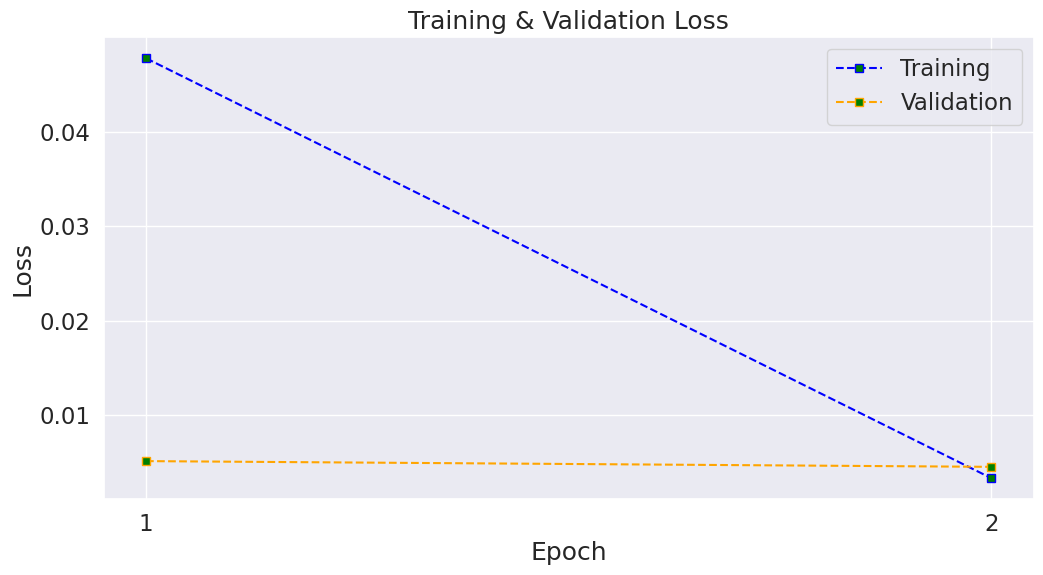

In [40]:
#plotting
sns.set(style='darkgrid')
sns.set_palette('plasma')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


plt.plot(df_stats['Training Loss'], 'b-o', label="Training",marker = 's',markerfacecolor='green',linestyle='--',color='blue')
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation",marker = 's',markerfacecolor='green',linestyle='--',color='orange')

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

ls=[]
for i in range(epochs):
    ls.append(i+1)
plt.xticks(ls)

plt.show()

# 6. Evaluation on test set

In [41]:
print("")
print('\033[1m'+"Running Test..."+ '\033[0m')
t0 = time.time()

y_test_true = []
y_test_pred = []
testdataset = []

y_test_true_full = []
y_test_pred_full = []
testdataset_full = []

model.eval()

for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, label_ids = batch #same as we did in training loop but only 1 epoch now


    with torch.no_grad(): #means we don't care about gradients and updating tensors
        outputs = model(input_ids, token_type_ids=None,
        attention_mask=input_mask,labels=label_ids)
        # For eval mode, the first result of outputs is logits (for training mode this was loss)
#             logits = outputs[0]
        loss, logits = outputs[:2]#  In context of deep learning the logits layer means the layer that feeds in to softmax (or other such normalization).

    loss = loss.mean()
    total_eval_loss += loss.item()


    # Get NER predict result
    logits = torch.argmax(F.log_softmax(logits,dim=2),dim=2)#feed logits into softmax and take the prediction that is maximal
    logits = logits.detach().cpu().numpy()

    # Get NER true result
    label_ids = label_ids.to('cpu').numpy()

    # Only predict the real word, mark=0, will not calculate
    input_mask = input_mask.to('cpu').numpy()


    # Compare the valuable predict result
    for i,mask in enumerate(input_mask):
        # Real one
        temp_1 = []
        # Predicted one
        temp_2 = []
        valtemp = []

        temp_1_full = []
        # Predicted one
        temp_2_full = []
        valtemp_full = []

        for j, m in enumerate(mask):
            # Mark=0, meaning its a pad word, dont compare
            if m :
                if tag2name[label_ids[i][j]] != "X" and tag2name[label_ids[i][j]] != "[CLS]" and tag2name[label_ids[i][j]] != "[SEP]" : # Exclude the X label
                    temp_1.append(tag2name[label_ids[i][j]])
                    temp_2.append(tag2name[logits[i][j]])
                    valtemp.append(input_ids[i][j].item())

                if tag2name[label_ids[i][j]] != "[CLS]" and tag2name[label_ids[i][j]] != "[SEP]" : # Exclude the X label
                    temp_1_full.append(tag2name[label_ids[i][j]])
                    temp_2_full.append(tag2name[logits[i][j]])
                    valtemp_full.append(input_ids[i][j].item())

            else:
                break

        #here are the two lists that contain true and pred labels.
        y_test_true.append(temp_1)
        y_test_pred.append(temp_2)
        testdataset.append(valtemp)

        y_test_true_full.append(temp_1_full)
        y_test_pred_full.append(temp_2_full)
        testdataset_full.append(valtemp_full)


avg_test_loss = total_eval_loss / len(test_dataloader)
test_time = format_time(time.time() - t0)

print("  (Num examples ={})".format(len(test_inputs)))
print("  (Batch size = {})\n".format(batch_num))
print("   Test loss: {}".format(avg_test_loss))
print("   F1-score: %f"%(f1_score(y_test_true, y_test_pred)))
print("   Accuracy: %f"%(accuracy_score(y_test_true, y_test_pred)))
print("   Test took: {:}".format(test_time))




Running Test...
  (Num examples =4084)
  (Batch size = 8)

   Test loss: 0.00696951716690819
   F1-score: 0.846298
   Accuracy: 0.957639
   Test took: 0:01:29


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: X seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [42]:
# classification report is meant for evaluation of tasks like NER (see doc)
# difference between f1_score of scikit-learn and classification_report is that classification_report
# merges B and I, resulting in lower f1
report = classification_report(y_test_true, y_test_pred)
print(report)


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           _       0.00      0.00      0.00         0
     problem       0.84      0.86      0.85      1824
        test       0.85      0.86      0.86      1182
   treatment       0.82      0.84      0.83      1233

   micro avg       0.84      0.85      0.85      4239
   macro avg       0.63      0.64      0.63      4239
weighted avg       0.84      0.85      0.85      4239



In [43]:
from sklearn.preprocessing import MultiLabelBinarizer

In [44]:
mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(labels)

In [45]:
y_test_true_binary = mlb.fit_transform(y_test_true)

In [46]:
y_test_true_binary.shape

(4080, 7)

In [47]:
y_test_pred_binary = mlb.fit_transform(y_test_pred)

In [48]:
y_test_pred_binary.shape

(4080, 8)

In [49]:
y_test_pred_binary = y_test_pred_binary[:, :7]

In [50]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test_true_binary, y_test_pred_binary))

0.9107843137254902


# 7. Predictions of test set - examples


In [51]:
len(y_test_true[0]),len(y_test_pred[0]), len(testdataset[0])

(19, 19, 19)

In [52]:
text= [tokenizer.decode(test) for test in testdataset]
tokenized_text_converted = [tokenizer.convert_ids_to_tokens(test) for test in testdataset]


In [53]:
text_full= [tokenizer.decode(test) for test in testdataset_full]
tokenized_text_converted_full = [tokenizer.convert_ids_to_tokens(test) for test in testdataset_full]


In [54]:
a = 2
print( '\n' + text_full[a])
print('\033[1m' + "Labels:      " + '\033[0m', y_test_true[a])
print('\033[1m' + "Predictions: "+ '\033[0m',y_test_pred[a])
print('\n')

print(tokenized_text_converted_full[a])




2019-06-18 07:55 am blood caltibc - 229 ferritn - greater th trf - 176 *
Labels:       ['O', 'O', 'O', 'O', 'B-test', 'O', 'O', 'B-test', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predictions:  ['O', 'O', 'O', 'B-test', 'B-test', 'O', 'O', 'B-test', 'O', 'O', 'O', 'B-test', 'O', 'O', 'O']


['▁2019', '-', '06', '-', '18', '▁', '07', ':55', '▁am', '▁blood', '▁cal', 'ti', 'bc', '▁', '-', '▁', '229', '▁', 'ferri', 't', 'n', '▁', '-', '▁greater', '▁', 'th', '▁', 't', 'rf', '▁', '-', '▁', '176', '▁*']


In [55]:
a = 7
print( '\n' +text_full[a])
print('\033[1m' + "Labels:      " + '\033[0m', y_test_true[a])
print('\033[1m' + "Predictions: "+ '\033[0m',y_test_pred[a])
print('\n')

print(tokenized_text_converted_full[a])



sigmoidoscopy.
Labels:       ['B-test', 'O']
Predictions:  ['B-test', 'O']


['▁sig', 'mo', 'ido', 's', 'copy', '▁', '.']


In [56]:
a = 11
print( '\n' +text_full[a])
print('\033[1m' + "Labels:      " + '\033[0m', y_test_true[a])
print('\033[1m' + "Predictions: "+ '\033[0m',y_test_pred[a])
print('\n')

print(tokenized_text_converted_full[a])



initial newborn exam :
Labels:       ['B-test', 'I-test', 'I-test', 'O']
Predictions:  ['O', 'O', 'O', 'O']


['▁initial', '▁new', 'born', '▁exam', '▁', ':']


In [57]:
a = 12
print( '\n' +text_full[a])
print('\033[1m' + "Labels:      " + '\033[0m', y_test_true[a])
print('\033[1m' + "Predictions: "+ '\033[0m',y_test_pred[a])
print('\n')

print(tokenized_text_converted_full[a])




64-year-old g5p5 postmenopausal for 10 years with a history of two months of progressive abdominal distention, crampy abdominal pain, urinary frequency and diarrhea.
Labels:       ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-problem', 'I-problem', 'I-problem', 'O', 'B-problem', 'I-problem', 'I-problem', 'O', 'B-problem', 'I-problem', 'O', 'B-problem', 'O']
Predictions:  ['O', 'B-problem', 'B-problem', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-problem', 'I-problem', 'I-problem', 'O', 'B-problem', 'I-problem', 'I-problem', 'O', 'B-problem', 'I-problem', 'O', 'B-problem', 'O']


['▁64', '-', 'year', '-', 'old', '▁g', '5', 'p', '5', '▁post', 'men', 'opa', 'us', 'al', '▁for', '▁10', '▁years', '▁with', '▁a', '▁history', '▁of', '▁two', '▁months', '▁of', '▁progressive', '▁abdominal', '▁dis', 'ten', 'tion', '▁', ',', '▁cramp', 'y', '▁abdominal', '▁pain', '▁', ',', '▁u', 'rina', 'ry', '▁frequency', '▁and', '▁diarrhea', '▁', '.']


In [58]:
a = 14
print( '\n' +text_full[a])
print('\033[1m' + "Labels:      " + '\033[0m', y_test_true[a])
print('\033[1m' + "Predictions: "+ '\033[0m',y_test_pred[a])
print('\n')

print(tokenized_text_converted_full[a])



the patient was given printed instructions for motor vehicle accident - trauma ( english ).
Labels:       ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-problem', 'O', 'O', 'O', 'O']
Predictions:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-problem', 'O', 'O', 'O', 'O']


['▁the', '▁patient', '▁was', '▁given', '▁printed', '▁instructions', '▁for', '▁motor', '▁vehicle', '▁accident', '▁', '-', '▁trauma', '▁', '(', '▁english', '▁', ')', '▁', '.']


In [59]:
a = 17
print( '\n' +text_full[a])
print('\033[1m' + "Labels:      " + '\033[0m', y_test_true[a])
print('\033[1m' + "Predictions: "+ '\033[0m',y_test_pred[a])
print('\n')

print(tokenized_text_converted_full[a])



3. hydrochlorothiazide question of dosage.
Labels:       ['O', 'B-treatment', 'O', 'O', 'O', 'O']
Predictions:  ['O', 'B-problem', 'O', 'O', 'B-problem', 'O']


['▁3', '.', '▁hydro', 'chloro', 'thia', 'z', 'ide', '▁question', '▁of', '▁do', 's', 'age', '▁', '.']


In [60]:
a = 25
print( '\n' +text_full[a])
print('\033[1m' + "Labels:      " + '\033[0m', y_test_true[a])
print('\033[1m' + "Predictions: "+ '\033[0m',y_test_pred[a])
print('\n')

print(tokenized_text_converted_full[a])



3. acetaminophen 500 mg tablet sig : two ( 2 ) tablet po q6h ( every 6 hours ).
Labels:       ['O', 'B-treatment', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predictions:  ['O', 'B-treatment', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


['▁3', '.', '▁a', 'cet', 'amino', 'phen', '▁500', '▁mg', '▁tablet', '▁sig', '▁', ':', '▁two', '▁', '(', '▁2', '▁', ')', '▁tablet', '▁po', '▁q', '6', 'h', '▁', '(', '▁every', '▁6', '▁hours', '▁', ')', '.']


In [61]:
a = 37
print( '\n' +text_full[a])
print('\033[1m' + "Labels:      " + '\033[0m', y_test_true[a])
print('\033[1m' + "Predictions: "+ '\033[0m',y_test_pred[a])
print('\n')

print(tokenized_text_converted_full[a])



please refer to the previously dictated operative note of 2016-12-30 by dr. lawrence.
Labels:       ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predictions:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


['▁please', '▁refer', '▁to', '▁the', '▁previously', '▁dictated', '▁', 'operative', '▁note', '▁of', '▁2016', '-', '12', '-', '30', '▁by', '▁dr', '.', '▁lawrence', '▁', '.']


In [62]:
# text = [tokenizer.convert_tokens_to_string(i) for i in tokenized_text_converted]


In [63]:
for a in range(1,len(y_test_pred)):
    print(tokenized_text_converted_full[a])

['▁reason', '▁for', '▁this', '▁examination', '▁', ':']
['▁2019', '-', '06', '-', '18', '▁', '07', ':55', '▁am', '▁blood', '▁cal', 'ti', 'bc', '▁', '-', '▁', '229', '▁', 'ferri', 't', 'n', '▁', '-', '▁greater', '▁', 'th', '▁', 't', 'rf', '▁', '-', '▁', '176', '▁*']
['▁he', 'mo', 'dynamic', 's', '▁', ':']
['▁mr', '.', '▁bre', 'utz', 'far', 'st', 'xe', 'i', '▁was', '▁recently', '▁diagnosed', '▁with', '▁acquired', '▁im', 'mun', 'ode', 'fic', 'i', 'ency', '▁syndrome', '▁when', '▁he', '▁had', '▁p', 'neu', 'mo', 'cy', 's', 'tis', '▁car', 'ini', 'i', '▁pneumonia', '▁on', '▁', '01', '/1', '7/', '91', '▁', '.']
['▁cbc', '▁', ':', '▁white', '▁blood', '▁cell', '▁count', '▁is', '▁8', '.', '8', '▁', ',', '▁he', 'mato', 'crit', '▁35', '.', '5', '▁plate', 'lets', '▁', '266', '▁', ',', '▁pt', '▁13', '▁', ',', '▁pt', '-', 't', '▁23', '.', '3', '▁', ',', '▁in', 'r', '▁was', '▁1', '.', '1', '▁', '.']
['▁diagnosis', '▁', ':']
['▁sig', 'mo', 'ido', 's', 'copy', '▁', '.']
['▁discharge', '▁instructions', '▁',


['▁all', 'er', 'gies', '▁', ':']
['▁as', '▁the', '▁c', 'x', 'r', '▁was', '▁without', '▁any', '▁evidence', '▁of', '▁p', 'na', '▁', ',', '▁or', '▁pt', 'x', '▁', ',', '▁the', '▁pt', '▁subsequently', '▁received', '▁a', '▁', 'cta', '▁to', '▁', 'evaluate', '▁for', '▁pe', '▁which', '▁revealed', '▁multi', 'fo', 'cal', '▁bilateral', '▁p', 'na', '▁but', '▁no', '▁pe', '▁', '.']
['▁is', '▁notable', '▁for', '▁depression', '▁', ',', '▁and', '▁she', '▁has', '▁been', '▁followed', '▁regularly', '▁by', '▁dr', '.', '▁frei', 'er', 'm', 'chir', 'd', '▁of', '▁nash', '▁health', '▁for', '▁several', '▁months', '▁with', '▁pharma', 'c', 'ologic', '▁treatment', '▁', ',', '▁which', '▁is', '▁apparently', '▁working', '▁well', '▁', '.']
['▁7', '.', '▁an', 'emia', '▁', '.']
['▁dictated', '▁by', '▁', ':']
['▁she', '▁uses', '▁a', '▁cane', '▁or', '▁walker', '▁for', '▁', 'ambul', 'ation', '▁', ',', '▁and', '▁is', '▁limited', '▁to', '▁one', '▁to', '▁two', '▁blocks', '▁', '.']
['▁please', '▁schedule', '▁an', '▁appointment'

# 9. Code snippets

In [64]:
# flatten1 = list(itertools.chain(*y_true))
# flatten2 = list(itertools.chain(*y_pred))
# tagsforf1 = []
# for tag in tags_vals[:-3]:
#     if tag != 'O':
#         tagsforf1.append(tag)

In [65]:
#https://datascience.stackexchange.com/questions/54907/model-cuda-in-pytorch
# if n_gpu >1:
#     model = torch.nn.DataParallel(model)
# model.cuda(device='cuda:0')
# model.to(torch.device('cuda:0'))

In [66]:
# params = list(model.named_parameters())
# print(len(params))
# for p in params[0:201]:
#     print(p[0], p[1].size())

In [67]:
# type(param_optimizer)
# type(optimizer_grouped_parameters)
# len(optimizer_grouped_parameters)

# type(optimizer_grouped_parameters[0])

# optimizer_grouped_parameters[1].keys()

# optimizer_grouped_parameters[0]['weight_decay_rate']

# optimizer_grouped_parameters[1]['weight_decay_rate']

# optimizer_grouped_parameters[0]['betas']

# optimizer_grouped_parameters[1]['betas']

# optimizer_grouped_parameters[1]['weight_decay']

# optimizer_grouped_parameters[1]['weight_decay']

# optimizer_grouped_parameters[0]['correct_bias']

# optimizer_grouped_parameters[1]['correct_bias']

In [68]:
# c =28
# print(list(attention_masks[c]))
# print(attention_masks_deprecated[c])
# for i in range(1,150):
#     if list(attention_masks[i]) != attention_masks_deprecated[i]:
#         print(i)

In [69]:
# tokenized_texts[0]
# tokenizer.tokenize(' '.join(sentences[0]))

In [70]:
# tokenizer.batch_encode_plus(sentences)['input_ids'][0]
# tokenizer.decode(tokenizer.batch_encode_plus(sentences)['input_ids'][0])
# tokenizer.decode(tokenizer.encode(' '.join(sentences[0])))
# tokenizer.decode(tokenizer.encode(sentences[0]))
# tokenizer.decode(tokenizer.encode('Diagnose revisie : ( Meerdere antwoorden mogelijk) Infectie'))

In [71]:
# def getmaxlength():
#     lowestcount =512
#     lowestcountindex = 0
#     for idx, onearray in enumerate(input_ids):
#         count=0
#         for number in reversed(onearray):
#             if number ==0:
#                 count += 1
#             else:
#                 if count < lowestcount:
#                     lowestcount = count
#                     lowestcountindex = idx
#                 break

#     maxlength = len(tokenized_texts[lowestcountindex])
#     return maxlength